In [2]:
!pip install qiskit
!pip install qiskit-aer # Install the qiskit-aer package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 92.1 MB/s eta 0:00:00


In [3]:
import numpy as np

# Import Qiskit
from qiskit  import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.circuit import IfElseOp
from qiskit import transpile # import the transpile function

# BIT-FLIP ERROR

$$
\begin{array}{|c|c|c|}
    \hline
    \textbf{cr[3]} & \textbf{cr[4]} & \textbf{Error Location} \\ \hline
    0 & 0 & \text{No error} \\ \hline
    1 & 1 & q_1 \text{ flipped} \\ \hline
    1 & 0 & q_0 \text{ flipped} \\ \hline
    0 & 1 & q_2 \text{ flipped} \\ \hline
\end{array}
$$


## State |000> or |111>

In [ ]:
# Step 0: if x = 0 => |000>       if x = 1 => |111>
x = 1

# Step 1: Create a 5-qubit circuit (3 data + 2 ancilla for error detection and correction)
qr = QuantumRegister(5, 'q')  # Quantum register with 5 qubits
cr = ClassicalRegister(5, 'c')  # Classical register with 5 classical bits
circuit = QuantumCircuit(qr, cr)

# Step 2: Encode the single bit
if x == 0:
    # Encoding |0⟩ -> |000⟩
    circuit.cx(qr[0], qr[1])
    circuit.cx(qr[0], qr[2])
else:
    # Encoding |1⟩ -> |111⟩
    circuit.x(qr[0])
    circuit.cx(qr[0], qr[1])
    circuit.cx(qr[0], qr[2])


# Step 3: Simulated error (choose one qubit to introduce an error)
#circuit.x(qr[0])
#circuit.x(qr[1])
circuit.x(qr[2])


# Step 4: Syndrome measurement to detect errors
circuit.cx(qr[0], qr[3])
circuit.cx(qr[1], qr[3])
circuit.cx(qr[1], qr[4])
circuit.cx(qr[2], qr[4])

# Step 5: Barrier before measurement
circuit.barrier([qr[3], qr[4]])

# Step 6: Measure the ancilla qubits (syndrome extraction)
circuit.measure([qr[3], qr[4]], [cr[3], cr[4]])

# Step 7: Apply correction based on measured syndrome
with circuit.if_test((cr[3], 1)):  # If cr[3] == 1
    with circuit.if_test((cr[4], 1)):  # If cr[4] == 1
        circuit.x(qr[1])  #  Correct q1
    with circuit.if_test((cr[4], 0)):  # If cr[4] == 0
         circuit.x(qr[0])  # Correct q_0

with circuit.if_test((cr[3], 0)):  # If cr[3] == 0
    with circuit.if_test((cr[4], 1)):  # If cr[4] == 1
      circuit.x(qr[2])  #  Correct q_2

# Step 8: Barrier before final measurement
circuit.barrier([qr[0], qr[1], qr[2]])

# Step 9: Final measurement (moved to the very end)
circuit.measure([qr[0], qr[1], qr[2]], [cr[0], cr[1], cr[2]])

# Print the corrected circuit
print(circuit)


     ┌───┐                                              ┌──────             »
q_0: ┤ X ├──■────■─────────■────────────────────────────┤       ────────────»
     └───┘┌─┴─┐  │         │                            │ If-0     ┌──────  »
q_1: ─────┤ X ├──┼─────────┼────■────■──────────────────┤       ───┤ If-1  ─»
          └───┘┌─┴─┐┌───┐  │    │    │                  └──╥───    └──╥───  »
q_2: ──────────┤ X ├┤ X ├──┼────┼────┼────■────────────────╫──────────╫─────»
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░ ┌─┐        ║          ║     »
q_3: ────────────────────┤ X ├┤ X ├──┼────┼───░─┤M├────────╫──────────╫─────»
                         └───┘└───┘┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐     ║          ║     »
q_4: ──────────────────────────────┤ X ├┤ X ├─░──╫─┤M├─────╫──────────╫─────»
                                   └───┘└───┘ ░  ║ └╥┘┌────╨────┐┌────╨────┐»
c: 5/════════════════════════════════════════════╩══╩═╡ c_3=0x1 ╞╡ c_4=0x1 ╞»
                                                 3  4 └─────────

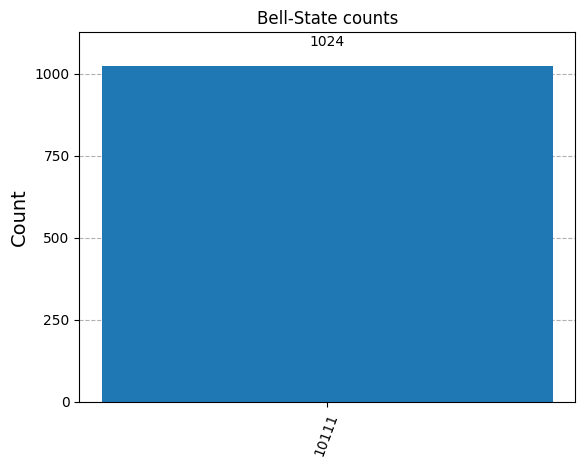

In [ ]:
# Transpile for simulator
simulator = AerSimulator()
circuit = transpile(circuit, simulator)

# Run and get counts
result = simulator.run(circuit).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Bell-State counts')

## State |y> = alfa * |000> + beta * |111>

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Create a 5-qubit circuit (3 data + 2 ancilla for error detection and correction)
qr = QuantumRegister(5, 'q')  # Quantum register with 5 qubits
cr = ClassicalRegister(5, 'c')  # Classical register with 5 classical bits
circuit = QuantumCircuit(qr, cr)

# Step 1: Initialize q0 in an arbitrary state
theta = 0.5
circuit.ry(2 * theta, qr[0])  # Create superposition state

# Step 2: Encode into three-qubit entangled state
circuit.cx(qr[0], qr[1])  # CNOT from q0 to q1
circuit.cx(qr[0], qr[2])  # CNOT from q0 to q2

# Step 3: Simulated error (choose one qubit to introduce an error)
#circuit.x(qr[0])
#circuit.x(qr[1])
circuit.x(qr[2])


# Step 4: Syndrome measurement to detect errors
circuit.cx(qr[0], qr[3])
circuit.cx(qr[1], qr[3])
circuit.cx(qr[1], qr[4])
circuit.cx(qr[2], qr[4])

# Step 5: Barrier before measurement
circuit.barrier([qr[3], qr[4]])

# Step 6: Measure the ancilla qubits (syndrome extraction)
circuit.measure([qr[3], qr[4]], [cr[3], cr[4]])

# Step 7: Apply correction based on measured syndrome
with circuit.if_test((cr[3], 1)):  # If cr[3] == 1
    with circuit.if_test((cr[4], 1)):  # If cr[4] == 1
        circuit.x(qr[1])  #  Correct q1
    with circuit.if_test((cr[4], 0)):  # If cr[4] == 0
         circuit.x(qr[0])  # Correct q_0

with circuit.if_test((cr[3], 0)):  # If cr[3] == 0
    with circuit.if_test((cr[4], 1)):  # If cr[4] == 1
      circuit.x(qr[2])  #  Correct q_2

# Step 8: Barrier before final measurement
circuit.barrier([qr[0], qr[1], qr[2]])

# Step 9: Final measurement (moved to the very end)
circuit.measure([qr[0], qr[1], qr[2]], [cr[0], cr[1], cr[2]])

# Print the corrected circuit
print(circuit)

     ┌───────┐                                              ┌──────  »
q_0: ┤ Ry(1) ├──■────■─────────■────────────────────────────┤       ─»
     └───────┘┌─┴─┐  │         │                            │ If-0   »
q_1: ─────────┤ X ├──┼─────────┼────■────■──────────────────┤       ─»
              └───┘┌─┴─┐┌───┐  │    │    │                  └──╥───  »
q_2: ──────────────┤ X ├┤ X ├──┼────┼────┼────■────────────────╫─────»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░ ┌─┐        ║     »
q_3: ────────────────────────┤ X ├┤ X ├──┼────┼───░─┤M├────────╫─────»
                             └───┘└───┘┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐     ║     »
q_4: ──────────────────────────────────┤ X ├┤ X ├─░──╫─┤M├─────╫─────»
                                       └───┘└───┘ ░  ║ └╥┘┌────╨────┐»
c: 5/════════════════════════════════════════════════╩══╩═╡ c_3=0x1 ╞»
                                                     3  4 └─────────┘»
«                                 ┌──────  ┌───┐ ───────┐  ───────┐          

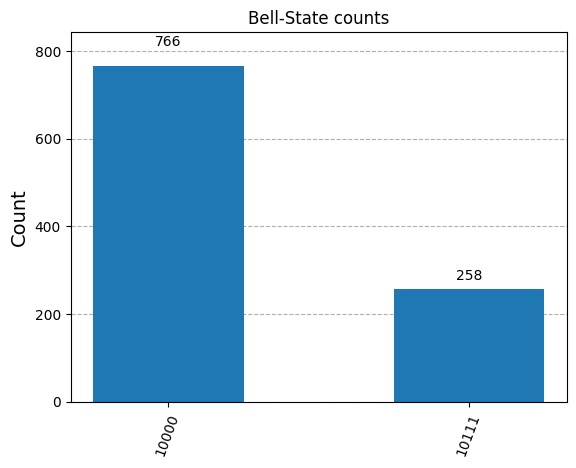

In [ ]:
# Transpile for simulator
simulator = AerSimulator()
circuit = transpile(circuit, simulator)

# Run and get counts
result = simulator.run(circuit).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Bell-State counts')

## Result

In this experiment, I successfully implemented a quantum error correction scheme that detects and corrects bit-flip errors. The results show that the final measurement outcomes are always either ∣000⟩∣000⟩ or ∣111⟩∣111⟩, confirming that the encoded logical qubit remains in a valid state despite introducing an error.

I started by encoding an initial superposition state into a three-qubit entangled state.

I intentionally introduced a bit-flip error on one of the data qubits (q2q2​) to test the error detection and correction mechanism.

Using syndrome measurements with the ancilla qubits (q3,q4q3​,q4​), I was able to detect the error.

Based on the measured syndrome, I applied the appropriate error correction using conditional gates.

The final measurement verified that my correction worked, as the output state was always either ∣000⟩∣000⟩ or ∣111⟩∣111⟩, ensuring the logical qubit’s integrity.

This confirms that my quantum error correction strategy effectively mitigates errors, which is a crucial step in building reliable quantum computing systems.

# PHASE ERROR

## State |y> = alfa * |000> + beta * |111>

In [21]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np

# Step 0: Create registers and circuit (3 data qubits + 2 ancilla)
qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qr, cr)

# Step 1: Initialize q0 in an arbitrary state
theta = 0.5
circuit.ry(2 * theta, qr[0])  # Put q0 into superposition

# Step 2: Encode using repetition code
circuit.cx(qr[0], qr[1])
circuit.cx(qr[0], qr[2])

# Step 3: Apply Hadamard to all 3 data qubits (convert phase flips into bit flips)
circuit.h(qr[0])
circuit.h(qr[1])
circuit.h(qr[2])

# Step 4: Simulate a phase error on one qubit (e.g., q0)
circuit.z(qr[0])


# Step 5: Undo Hadamard (revert to bit-flip detection basis)
circuit.h(qr[0])
circuit.h(qr[1])
circuit.h(qr[2])

# Step 6: Syndrome extraction via ancilla
circuit.cx(qr[0], qr[3])
circuit.cx(qr[1], qr[3])
circuit.cx(qr[1], qr[4])
circuit.cx(qr[2], qr[4])

# Step 7: Barrier and syndrome measurement
circuit.barrier([qr[3], qr[4]])
circuit.measure(qr[3], cr[3])
circuit.measure(qr[4], cr[4])

# Step 8: Apply correction using classical control flow
with circuit.if_test((cr[3], 1)):
    with circuit.if_test((cr[4], 1)):
        circuit.x(qr[1])  # Correct q1
    with circuit.if_test((cr[4], 0)):
        circuit.x(qr[0])  # Correct q0
with circuit.if_test((cr[3], 0)):
    with circuit.if_test((cr[4], 1)):
        circuit.x(qr[2])  # Correct q2

# Step 9: Final barrier and data measurement
circuit.barrier([qr[0], qr[1], qr[2]])
circuit.measure([qr[0], qr[1], qr[2]], [cr[0], cr[1], cr[2]])

# Print the circuit
print("\n=== Quantum Error Correction Circuit ===")
print(circuit)



=== Quantum Error Correction Circuit ===
     ┌───────┐          ┌───┐┌───┐┌───┐                               ┌──────  »
q_0: ┤ Ry(1) ├──■────■──┤ H ├┤ Z ├┤ H ├──■────────────────────────────┤       ─»
     └───────┘┌─┴─┐  │  ├───┤├───┤└───┘  │                            │ If-0   »
q_1: ─────────┤ X ├──┼──┤ H ├┤ H ├───────┼────■────■──────────────────┤       ─»
              └───┘┌─┴─┐├───┤├───┤       │    │    │                  └──╥───  »
q_2: ──────────────┤ X ├┤ H ├┤ H ├───────┼────┼────┼────■────────────────╫─────»
                   └───┘└───┘└───┘     ┌─┴─┐┌─┴─┐  │    │   ░ ┌─┐        ║     »
q_3: ──────────────────────────────────┤ X ├┤ X ├──┼────┼───░─┤M├────────╫─────»
                                       └───┘└───┘┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐     ║     »
q_4: ────────────────────────────────────────────┤ X ├┤ X ├─░──╫─┤M├─────╫─────»
                                                 └───┘└───┘ ░  ║ └╥┘┌────╨────┐»
c: 5/══════════════════════════════════════════════════════════╩══╩

In [22]:
# Simulate the state before any measurement (exclude classical logic)
pre_measurement_circuit = QuantumCircuit(qr)
pre_measurement_circuit.ry(2 * theta, qr[0])
pre_measurement_circuit.cx(qr[0], qr[1])
pre_measurement_circuit.cx(qr[0], qr[2])
pre_measurement_circuit.h(qr[0])
pre_measurement_circuit.h(qr[1])
pre_measurement_circuit.h(qr[2])
pre_measurement_circuit.p(np.pi / 2, qr[0])
pre_measurement_circuit.h(qr[0])
pre_measurement_circuit.h(qr[1])
pre_measurement_circuit.h(qr[2])
pre_measurement_circuit.cx(qr[0], qr[3])
pre_measurement_circuit.cx(qr[1], qr[3])
pre_measurement_circuit.cx(qr[1], qr[4])
pre_measurement_circuit.cx(qr[2], qr[4])

# Analyze quantum state
state = Statevector.from_instruction(pre_measurement_circuit)
amplitudes = state.data
print("\n=== Quantum State Before Measurement ===")
for i, amp in enumerate(amplitudes):
    if np.abs(amp) > 1e-6:
        bitstring = format(i, '05b')
        phase = np.angle(amp)
        print(f"|{bitstring}>: Amplitude = {amp:.4f}, Phase = {phase:.3f} rad")



=== Quantum State Before Measurement ===
|00000>: Amplitude = 0.4388+0.4388j, Phase = 0.785 rad
|00111>: Amplitude = 0.2397+0.2397j, Phase = 0.785 rad
|01001>: Amplitude = 0.4388-0.4388j, Phase = -0.785 rad
|01110>: Amplitude = 0.2397-0.2397j, Phase = -0.785 rad


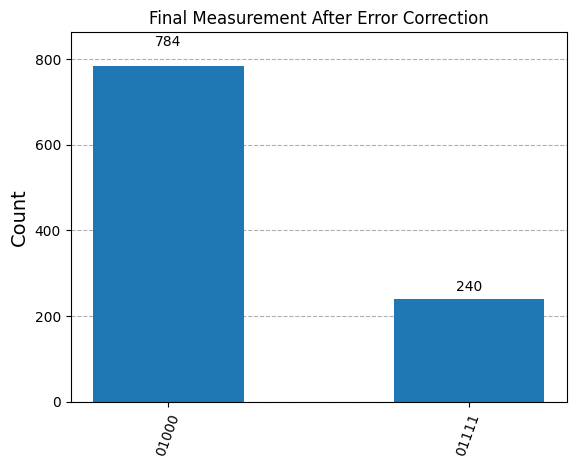

In [23]:
# Use AerSimulator to run full circuit with classical conditionals
simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
result = simulator.run(compiled_circuit).result()

# Extract and plot final measurement counts
counts = result.get_counts()
plot_histogram(counts, title="Final Measurement After Error Correction")


## result

In this experiment, I implemented a quantum error correction strategy capable of detecting and correcting bit-phase (Z-type) errors. Unlike pure bit-flip errors, phase errors introduce a shift in the relative phase between |0⟩ and |1⟩, which can be harder to detect directly using standard bit-flip detection.

To address this, I used Hadamard gates to convert the phase error into an equivalent bit-flip error, using the following identity:
H⋅Z⋅H=X
H⋅Z⋅H=X

This transformation enabled me to use the same syndrome detection logic (based on CNOT gates and ancilla qubits) as in the bit-flip error correction scheme.

I applied a phase-flip error (Z gate) to one of the data qubits (q0). Then, using ancilla qubits (q3, q4), I performed syndrome extraction via entanglement. The measurement outcome of the ancilla qubits determined the error location, and the corresponding correction was applied using conditional X gates.
✅ Results

The final measurement outcomes of the data qubits were:

    |000⟩ → representing the logical 0

    |111⟩ → representing the logical 1

These outcomes indicate that the encoded logical qubit was successfully restored to a valid state, despite the presence of a bit-phase error. This confirms that the quantum error correction strategy effectively detected and corrected the error, preserving the integrity of the logical qubit.